# Import Libraries

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Background

The goal of this analysis is to build a model to attempt to predict the salary of a player based on their performances in NHL (National Hockey League) ice hockey games.

Data Source: https://www.kaggle.com/datasets/martinellis/nhl-game-data

The most used files within the dataset are the `game.csv`, `game_skater_stats.csv`, `player_info.csv`. The files contain data for NHL games between the 2000-2001 season and the 2019-2020 season, however only data between 2010-2011 and 2019-2020 are used as prior to 2010, contract details were difficult to find and were formatted differently than modern contracts.

`game.csv` contains information such as game type (regular season or playoffs), date and time, teams involved, the score of the game and the game outcome. Also contains which team is the home team, the name of the venue, and time zone.

`game_skater_stats.csv` contains game-by-game performance for each player. This contains information such as unique player identifier, the team they played for, and individual statistics for that player in that game.

The individual statistics involve playing time (minutes), goals, assists (first or second passes prior to a goal), points (goals + assists), plus/minus (a player starts each game at 0, gain +1 if they are on the ice when a goal is scored by their team. They lose -1 if they are on the ice when a goal is scored by the opposing team.), giveaways, takeaways, faceoff wins/losses.

Some statistics are also tracked at different situations. There are even strength or 5v5 situations, there are short handed or 4v5 situations, and there are power play or 5v4 situations.

`player_info.csv` contains identifying information for each player such as their names, nationality, position, birth date, height, weight, and the way they hold the stick (shoots left or right).

This data from the dataset is cleaned and merged. Additional data from a 3rd party site contains the salaries for each player. This is per season as contracts can change between seasons. The salary is counted as the AAV or annual average value of a contract signed, which is the total value of the contract (included bonuses) divided by the number of years.

# Setup Data

Read combined 10 seasons worth of statistics from merge script. Ensure all null values removed.

Drop specific identifying features to prevent model from learning from these features.

Create X and y variables by selecting or dropping features.

In [25]:
df = pd.read_csv('combinedstats.csv')
df.dropna(inplace=True)
df['age'] = df[['season', 'birthDate']].apply(lambda x: int(x['season'][:4]) - int(x['birthDate'][:4]), axis=1)
X = df.drop(['player_id', 'firstName', 'lastName', 'season', 'salary', 'avgTimeOnIce', 'avgPowerPlayTimeOnIce', 'avgShortHandedTimeOnIce', 'birthDate'], axis=1)
y = df.filter(['salary'])

View data. 30 features. 8265 training samples.

In [26]:
X

,primaryPosition,shootsCatches,gamesPlayed,goals,assists,points,pointsPerGame,plusMinus,shots,shootingPercentage,...,turnoverDifferential,powerPlayGoals,powerPlayAssists,powerPlayPoints,powerPlayTimeOnIce,shortHandedGoals,shortHandedAssists,shortHandedPoints,shortHandedTimeOnIce,age
0,C,L,40,4,11,15,0.38,-4,79,5.06,...,1,1,5,6,6083.0,0,0,0,23.0,40
1,RW,L,81,14,34,48,0.59,13,132,10.61,...,-16,6,11,17,13042.0,0,1,1,3508.0,42
2,C,R,18,2,0,2,0.11,-1,11,18.18,...,-6,0,0,0,65.0,0,0,0,2521.0,39
3,D,R,47,0,8,8,0.17,-9,23,0.00,...,-11,0,0,0,403.0,0,0,0,8023.0,39
4,D,L,82,16,46,62,0.76,-2,175,9.14,...,0,7,32,39,19932.0,0,1,1,13142.0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,LW,L,12,1,0,1,0.08,-1,15,6.67,...,2,0,0,0,10.0,0,0,0,67.0,23
8261,RW,L,2,0,0,0,0.00,0,1,0.00,...,0,0,0,0,0.0,0,0,0,0.0,26
8262,LW,L,16,0,0,0,0.00,-3,9,0.00,...,-2,0,0,0,2.0,0,0,0,70.0,22
8263,LW,L,37,2,3,5,0.14,5,23,8.70,...,1,0,0,0,66.0,0,0,0,205.0,26


Training contract salaries. Range from ~800,000 to ~12,000,000.

In [27]:
y

,salary
0,1250000
1,1000000
2,500000
3,1000000
4,6200000
...,...
8260,925000
8261,792500
8262,741667
8263,842500


Look at datatypes for each feature. Large amount of `int` datatypes.

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8265 entries, 0 to 8264
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   primaryPosition       8265 non-null   object 
 1   shootsCatches         8265 non-null   object 
 2   gamesPlayed           8265 non-null   int64  
 3   goals                 8265 non-null   int64  
 4   assists               8265 non-null   int64  
 5   points                8265 non-null   int64  
 6   pointsPerGame         8265 non-null   float64
 7   plusMinus             8265 non-null   int64  
 8   shots                 8265 non-null   int64  
 9   shootingPercentage    8265 non-null   float64
 10  penaltyMinutes        8265 non-null   int64  
 11  timeOnIce             8265 non-null   float64
 12  faceOffWins           8265 non-null   int64  
 13  faceOffLosses         8265 non-null   int64  
 14  faceOffTaken          8265 non-null   int64  
 15  faceOffPercentage    

Look at descriptive statistics for each feature. Some features are binary (0/1), others in the range of tens or hundreds such as goals, assists and points, while other values such as time on ice can be in the tens of thousands.

In [29]:
X.describe()

,gamesPlayed,goals,assists,points,pointsPerGame,plusMinus,shots,shootingPercentage,penaltyMinutes,timeOnIce,...,turnoverDifferential,powerPlayGoals,powerPlayAssists,powerPlayPoints,powerPlayTimeOnIce,shortHandedGoals,shortHandedAssists,shortHandedPoints,shortHandedTimeOnIce,age
count,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,...,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000,8265.000000
mean,49.813914,7.748215,13.112765,20.860980,0.350463,-0.304537,85.018391,7.768797,26.644404,49603.275741,...,-3.556564,1.654567,3.151845,4.806413,4381.523775,0.222747,0.229522,0.452269,3460.525590,26.214156
std,27.269557,8.699116,12.812865,20.230889,0.262721,9.709119,69.181761,7.701502,26.188926,33116.361570,...,15.440702,2.820132,5.047696,7.208873,5242.466339,0.620804,0.569004,0.951982,4067.840771,4.388130
min,1.000000,0.000000,0.000000,0.000000,0.000000,-46.000000,1.000000,0.000000,0.000000,169.000000,...,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,26.000000,1.000000,3.000000,4.000000,0.160000,-5.000000,25.000000,3.120000,8.000000,18565.000000,...,-10.000000,0.000000,0.000000,0.000000,172.000000,0.000000,0.000000,0.000000,93.000000,23.000000
50%,57.000000,5.000000,9.000000,15.000000,0.290000,-1.000000,74.000000,7.140000,20.000000,50746.000000,...,-1.000000,0.000000,1.000000,1.000000,1496.000000,0.000000,0.000000,0.000000,1514.000000,26.000000
75%,75.000000,12.000000,20.000000,32.000000,0.500000,4.000000,129.000000,11.110000,37.000000,76484.000000,...,4.000000,2.000000,5.000000,7.000000,8117.000000,0.000000,0.000000,1.000000,6321.000000,29.000000
max,84.000000,60.000000,87.000000,128.000000,3.000000,49.000000,398.000000,100.000000,238.000000,144714.000000,...,74.000000,25.000000,38.000000,48.000000,23624.000000,7.000000,6.000000,9.000000,20797.000000,45.000000


Transform features to ensure they work with the selected models.

Remap values to be numeric rather than text.

Also normalize features as there is such a large range in values.

In [30]:
X['shootsCatches'] = X['shootsCatches'].apply(lambda x: 1 if x == 'L' else 0)
positionMap = {'C': 0, 'D': 1, 'LW': 2, 'RW': 3}
X['primaryPosition'] = X['primaryPosition'].map(positionMap)
X_normalized=(X-X.min())/(X.max()-X.min())

In [31]:
X_normalized

,primaryPosition,shootsCatches,gamesPlayed,goals,assists,points,pointsPerGame,plusMinus,shots,shootingPercentage,...,turnoverDifferential,powerPlayGoals,powerPlayAssists,powerPlayPoints,powerPlayTimeOnIce,shortHandedGoals,shortHandedAssists,shortHandedPoints,shortHandedTimeOnIce,age
0,0.000000,1.0,0.469880,0.066667,0.126437,0.117188,0.126667,0.442105,0.196474,0.0506,...,0.580460,0.04,0.131579,0.125000,0.257492,0.0,0.000000,0.000000,0.001106,0.814815
1,1.000000,1.0,0.963855,0.233333,0.390805,0.375000,0.196667,0.621053,0.329975,0.1061,...,0.482759,0.24,0.289474,0.354167,0.552066,0.0,0.166667,0.111111,0.168678,0.888889
2,0.000000,0.0,0.204819,0.033333,0.000000,0.015625,0.036667,0.473684,0.025189,0.1818,...,0.540230,0.00,0.000000,0.000000,0.002751,0.0,0.000000,0.000000,0.121219,0.777778
3,0.333333,0.0,0.554217,0.000000,0.091954,0.062500,0.056667,0.389474,0.055416,0.0000,...,0.511494,0.00,0.000000,0.000000,0.017059,0.0,0.000000,0.000000,0.385777,0.777778
4,0.333333,1.0,0.975904,0.266667,0.528736,0.484375,0.253333,0.463158,0.438287,0.0914,...,0.574713,0.28,0.842105,0.812500,0.843718,0.0,0.166667,0.111111,0.631918,0.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,0.666667,1.0,0.132530,0.016667,0.000000,0.007812,0.026667,0.473684,0.035264,0.0667,...,0.586207,0.00,0.000000,0.000000,0.000423,0.0,0.000000,0.000000,0.003222,0.185185
8261,1.000000,1.0,0.012048,0.000000,0.000000,0.000000,0.000000,0.484211,0.000000,0.0000,...,0.574713,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.296296
8262,0.666667,1.0,0.180723,0.000000,0.000000,0.000000,0.000000,0.452632,0.020151,0.0000,...,0.563218,0.00,0.000000,0.000000,0.000085,0.0,0.000000,0.000000,0.003366,0.148148
8263,0.666667,1.0,0.433735,0.033333,0.034483,0.039062,0.046667,0.536842,0.055416,0.0870,...,0.580460,0.00,0.000000,0.000000,0.002794,0.0,0.000000,0.000000,0.009857,0.296296


Pairplot features. (Can take a while to run)

In [32]:
#sns.pairplot(X_new)

Split data 75/25

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

# EDA

See `dash` dashboard script to launch and explore data.

Build collection of base models to determine which model to use.

In [34]:
model_names = []
model_mse = []
model_rmse = []
model_rmse_cv = []
model_mae = []
model_r2 = []
results = y_test.copy()

# Models

Begin process of building models, eventually getting to the final optimized model.

### Lasso

In [35]:
reg = Lasso()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Lasso')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Lasso pred'] = y_pred.tolist()

C:\Users\Jacky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e+14, tolerance: 2.634e+12
  model = cd_fast.enet_coordinate_descent(


### Ridge

In [36]:
reg = Ridge()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Ridge')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Ridge pred'] = y_pred

### Decision Tree

In [37]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('Decision Tree')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['Decision Tree pred'] = y_pred.tolist()

### XGBoost

In [38]:
reg = XGBRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('XGBoost')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['XGBoost pred'] = y_pred.tolist()

In [39]:
data = {'model_name': model_names, 'model_mse': model_mse, 'model_rmse': model_rmse, 'model_mae': model_mae, 'model_r2': model_r2}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.sort_values(by='model_rmse')

,model_name,model_mse,model_rmse,model_mae,model_r2
3,XGBoost,1.446028e+12,1.202509e+06,7.992291e+05,0.671195
0,Lasso,1.585439e+12,1.259142e+06,9.388003e+05,0.639496
1,Ridge,1.589474e+12,1.260743e+06,9.379299e+05,0.638578
2,Decision Tree,2.873168e+12,1.695042e+06,1.059088e+06,0.346686


XGBoost best model, decision tree severly underperforms rest of models.

Lasso outperforms Ridge in this situation, and did so consistently in multiple runs.

## Results Plot

Plot the predictions versus the true values from the best model, XGBoost.

May need to rerun to get proper figure size.

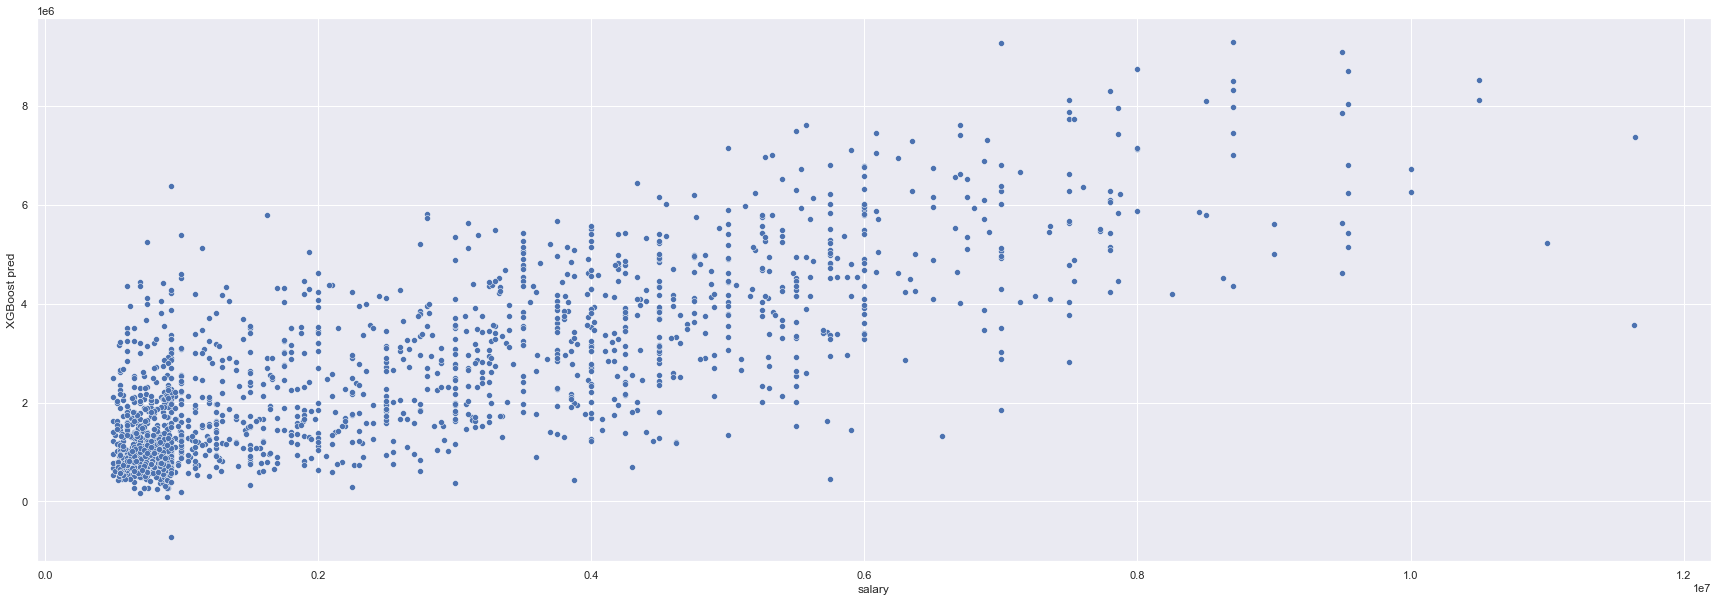

In [40]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.scatterplot(x='salary', y='XGBoost pred', data=results);

# RFECV

Use RFE (recursive feature eliminiation) to remove some features to attempt to remove redundant or correlated or insignificant features. Use 5-fold cross validation on the training dataset.

Print the supports. Any features with `True` will be included in the new model, any features with `False` will be left out.

In [41]:
reg = XGBRegressor()
selector = RFECV(reg, step=1, cv=5).fit(X_train, y_train)
for feature in zip(X_train.columns, selector.get_support()):
    print(feature)

('primaryPosition', False)
('shootsCatches', False)
('gamesPlayed', True)
('goals', False)
('assists', False)
('points', False)
('pointsPerGame', True)
('plusMinus', True)
('shots', True)
('shootingPercentage', True)
('penaltyMinutes', True)
('timeOnIce', True)
('faceOffWins', True)
('faceOffLosses', True)
('faceOffTaken', True)
('faceOffPercentage', True)
('hits', True)
('blocks', True)
('takeaways', True)
('giveaways', True)
('turnoverDifferential', True)
('powerPlayGoals', True)
('powerPlayAssists', True)
('powerPlayPoints', True)
('powerPlayTimeOnIce', True)
('shortHandedGoals', True)
('shortHandedAssists', False)
('shortHandedPoints', True)
('shortHandedTimeOnIce', True)
('age', True)


Rankings of importance of the features.

In [42]:
print(f'Feature Ranking: {selector.ranking_}')

Feature Ranking: [7 6 1 5 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1]


Compare the RFE model to the previous models.

In [43]:
mask = selector.get_support()
features_list = np.array(list(X_train.columns))
best_features = features_list[mask]
X_train = X_train[best_features]
X_test = X_test[best_features]
reg = selector.estimator_
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('XGBoost RFECV')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['XGBoost pred'] = y_pred.tolist()
data = {'model_name': model_names, 'model_mse': model_mse, 'model_rmse': model_rmse, 'model_mae': model_mae, 'model_r2': model_r2}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.sort_values(by='model_rmse')

,model_name,model_mse,model_rmse,model_mae,model_r2
3,XGBoost,1.446028e+12,1.202509e+06,7.992291e+05,0.671195
4,XGBoost RFECV,1.458414e+12,1.207648e+06,8.029615e+05,0.668379
0,Lasso,1.585439e+12,1.259142e+06,9.388003e+05,0.639496
1,Ridge,1.589474e+12,1.260743e+06,9.379299e+05,0.638578
2,Decision Tree,2.873168e+12,1.695042e+06,1.059088e+06,0.346686


Model performance decreased? That should not happen.

# Grid Search

Use gridsearch with 5 fold cross validation to increase performance. Use n_jobs=-1 to run parallel.

Also use alpha as regularization term rather than alpha as Lasso outperformed Ridge.

In [44]:
eta = [0.01, 0.1, 0.2, 0.3]
max_depth = [3, 6, 9, 12, 15]
gamma = [0, 0.1, 0.5, 1, 5, 10]
lambda_ = [0.1, 0.5, 1] #L2
alpha_ = [0, 1] #L1
param_grid = dict(eta=eta, max_depth=max_depth, gamma=gamma, reg_alpha=alpha_)
grid = GridSearchCV(estimator=reg, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [45]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.659452 using {'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'reg_alpha': 1}


Select best model and compare performance to previous models.

In [46]:
reg = grid_result.best_estimator_
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
model_names.append('XGBoost RFECV + Tuned')
model_mse.append(MSE)
model_rmse.append(np.sqrt(MSE))
model_mae.append(MAE)
model_r2.append(R2)
results['XGBoost pred'] = y_pred.tolist()
data = {'model_name': model_names, 'model_mse': model_mse, 'model_rmse': model_rmse, 'model_mae': model_mae, 'model_r2': model_r2}
metrics_df = pd.DataFrame.from_dict(data)
metrics_df.sort_values(by='model_rmse')

,model_name,model_mse,model_rmse,model_mae,model_r2
5,XGBoost RFECV + Tuned,1.351207e+12,1.162414e+06,7.911274e+05,0.692756
3,XGBoost,1.446028e+12,1.202509e+06,7.992291e+05,0.671195
4,XGBoost RFECV,1.458414e+12,1.207648e+06,8.029615e+05,0.668379
0,Lasso,1.585439e+12,1.259142e+06,9.388003e+05,0.639496
1,Ridge,1.589474e+12,1.260743e+06,9.379299e+05,0.638578
2,Decision Tree,2.873168e+12,1.695042e+06,1.059088e+06,0.346686


# Results

Using a variety of metrics (MSE, RMSE, MAE, R^2), a tuned and feature selected XGBoost model was the highest performing model of the group. While XGBoost with RFE had worse performance than base model XGBoost by 0.002 R^2, and ~5,000 in salary for RMSE, and ~3,000 in salary for MSE, the tuned + RFE XGBoost ensemble model had the highest R^2 and the lowest error across all metrics.

Decision trees were consistently the worst model by every metric.

Lasso and Ridge linear models had very comparable results to the XGBoost base model, but fell behind after tuning.

In the future, would like to increase amount of data by increasing the scope of seasons.

It would also be beneficial to minimize run-to-run variance with random states and ensure better consistency.